# Introduction

In this lab we will learn about SARSA, Q learning using the windy gridworld setup.

### Windy Grid world
A picture of what this environment actually looks like can be found [here](https://www.researchgate.net/profile/Markus_Dumke/publication/320890681/figure/fig1/AS:763210537922560@1558974980641/The-windy-gridworld-task-The-goal-is-to-move-from-the-start-state-S-to-the-goal-state-G.jpg)
- Agent will begin at t'S' and terminate at 'G'
- Numbers on the bottom represent how many squares the agent will be pushed
- Only standard moves(Right, Left, up, down) are used to learn this environment.

![picture](https://www.researchgate.net/profile/Markus-Dumke/publication/320890681/figure/fig1/AS:763210537922560@1558974980641/The-windy-gridworld-task-The-goal-is-to-move-from-the-start-state-S-to-the-goal-state-G.jpg)

### Importing Libaries


* **gym** : RL Toolkit library
* **defaultdict**: A defaultdict works exactly like a normal dict, but it is initialized with a function that takes no arguments and provides the default value for a nonexistent key. 
* **pandas**: pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [1]:
!pip install gym==0.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete
%matplotlib inline
import gym
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import namedtuple
import pandas as pd
from collections import defaultdict

## 1. Environment Programming

### Creating the windy world environment.

In this section we define a different type grid world environment which is a windy gridworld environment. The differnece between this and other grid world environenment is that here we need to account for the wind. That is, in this class the trnsition probability is a fucntion of current state and the wind.

In [3]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [4]:
env = WindyGridworldEnv()

## 2. Agent Programming

### Creating Policy

In this section we are defining the policy for the agent, which is a epsilon greedy policy.


In [5]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    probs = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    probs[best_action] += 1.0 - epsilon

    return probs

## 3. Expriment Programming

### 3-a. SARSA

SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
 
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
 
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.

In [6]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes))
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        # Initialize the first state and first action
        state = env.reset()
        action_probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = epsilon_greedy_policy(Q, next_state, env.action_space.n, epsilon)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Sarsa Update
            ### Start your code here - 2 lines###
            sarsa_target = reward + discount_factor * Q[next_state][next_action]
            sarsa_delta = sarsa_target - Q[state][action]
            Q[state][action] += alpha * sarsa_delta
            ### End your code here ###
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

### 3-b. Qlearning

 Learn to solve the environment using Q-learning
 
    :param episodes: Number of episodes to run (int)
    :param alpha: How fast it will converge to a point (float [0, 1])
    :param discount: How much future events lose their value (float [0, 1])
    :param epsilon: chance a random move is selected (float [0, 1])
    :return: x,y points to graph

In [7]:
def Q_learning(episodes, alpha, discount, epsilon):

    # Keeps track of useful statistics
    stats = EpisodeStats(
    episode_lengths=np.zeros(episodes),
    episode_rewards=np.zeros(episodes))
  
    # Links state to action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Points to plot
    # number of episodes
    x = np.arange(episodes)
    # Number of steps
    y = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()

        for step in range(10000):

            # Select and take action
            probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)

            # Qlearning Update
            ### Start your code here - 2 line ###
            qlearning_target = reward + discount * np.amax(Q[next_state])
            qlearning_delta = qlearning_target - Q[state][action]
            Q[state][action] += alpha * qlearning_delta
            ### End your code here ####
            stats.episode_rewards[episode] += reward
            stats.episode_lengths[episode] = step

            if done:
                y[episode] = step
                break

            state = next_state

    return x, y, stats

### 3-c. Running the Experiment

#### i. Initiaization

In [8]:
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

# Q Learning
episodes_ql = 300
alpha_ql = 0.5
discount_ql = 0.9
epsilon_ql = 0.05
_lambda = 0.

# SARSA
episodes_sarsa = 300
discount_factor_sarsa=1.0
alpha_sarsa=0.5
epsilon_sarsa=0.1

#### ii. Function to Plot the graph generated from SARSA

In [9]:
def plot_episode_stats(stats, stats_q,smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
    ax.plot(stats.episode_lengths, label='SARSA')
    # ax.plot(stats_q.episode_lengths, label='Q-Learning')
    ax.legend(loc='lower right')
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    # rewards_smoothed_q = pd.Series(stats_q.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    ax.plot(rewards_smoothed, label='SARSA')
    # ax.plot(rewards_smoothed_q, label='Q Learning')
    ax.legend(loc='lower right')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))
    ax.plot(np.cumsum(stats_q.episode_lengths), np.arange(len(stats_q.episode_lengths)), label='Q-Learning')
    ax.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)), label='SARSA')
    ax.legend(loc='lower right')
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

#### iii. Plotting graph for Qlearning

In [10]:
def plot_Q_learning(x, y):
  fig4 = plt.figure(figsize=(10,5))
  _, ax = plt.subplots()
  ax.plot(x, y)

  ax.set(xlabel='Episodes', ylabel='steps',
        title='Episodes vs steps')
  ax.grid()

  plt.show()


#### iv.Generating Steps vs Episodes for Q Learning

<Figure size 720x360 with 0 Axes>

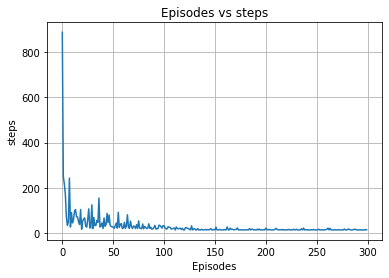

In [11]:
x, y, stats_q = Q_learning(episodes_ql, alpha_ql, discount_ql, epsilon_ql)
plot_Q_learning(x,y)

#### v. Comparing SARSA and Q Learning

Episode 100/300.
Episode 200/300.
Episode 300/300.


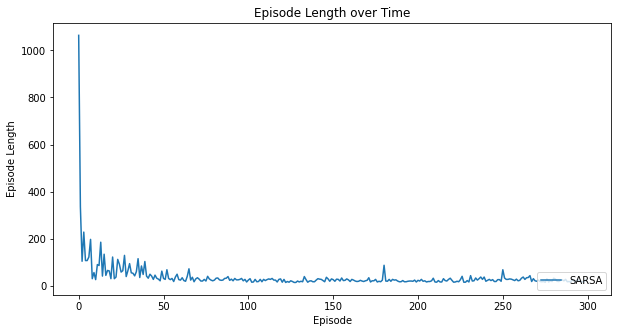

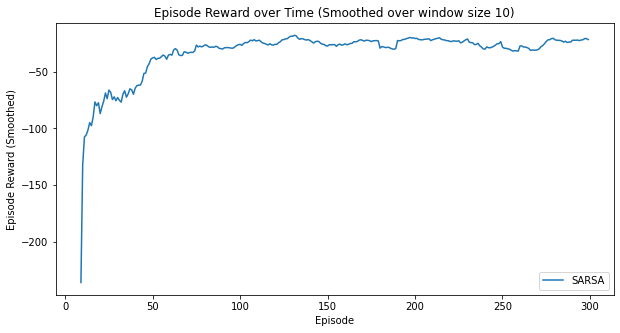

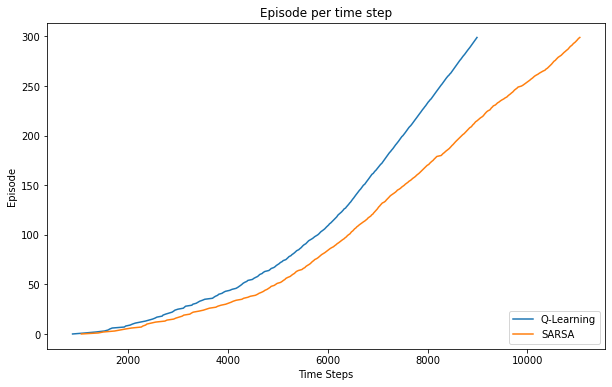

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x432 with 1 Axes>)

In [12]:
Q, stats = sarsa(env, episodes_sarsa, discount_factor_sarsa, alpha_sarsa, epsilon_sarsa)
plot_episode_stats(stats, stats_q)

#### v. Comparing SARSA and Q learning for a very small alpha(0.01) and large episodes(120000)

In [13]:
alpha_sarsa = 0.01
alpha_ql = 0.5
episodes_sarsa = episodes_ql = 1000

Episode 100/1000.
Episode 200/1000.
Episode 300/1000.
Episode 400/1000.
Episode 500/1000.
Episode 600/1000.
Episode 700/1000.
Episode 800/1000.
Episode 900/1000.
Episode 1000/1000.


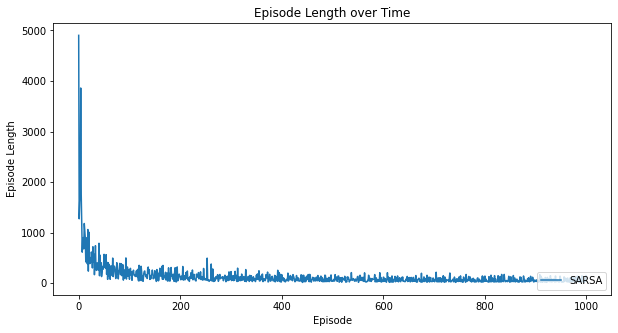

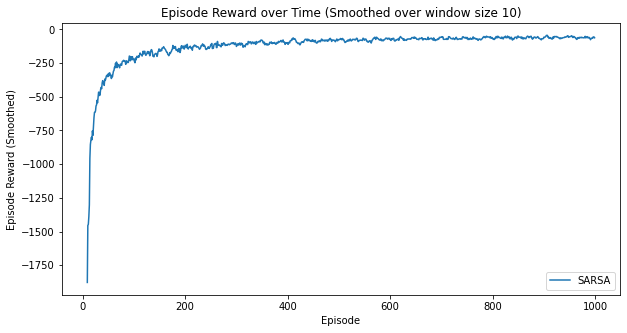

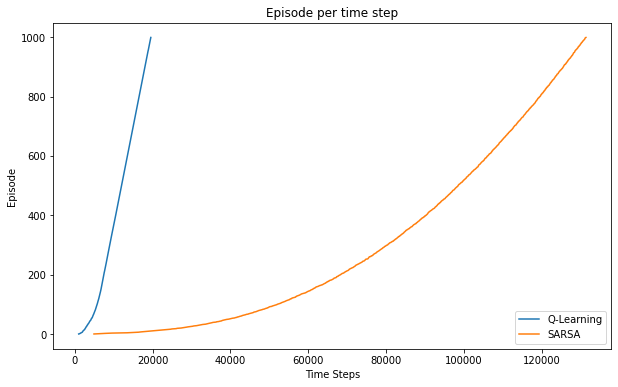

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x432 with 1 Axes>)

In [14]:
Q, stats = sarsa(env, episodes_sarsa, discount_factor_sarsa, alpha_sarsa, epsilon_sarsa)
_, _, stats_q = Q_learning(episodes_ql, alpha_ql, discount_ql, epsilon_ql)
plot_episode_stats(stats, stats_q)